In [8]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import sys
# sys.path.append('..')
from template import utils
import pdb

In [2]:
utils.set_random_seeds()

# Task 1

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: freddie7 (luke_team). Use `wandb login --relogin` to force relogin


True

In [4]:
# Downloading and Loading Dataset
svhn_tf = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # transforms.Pad(2),
      #  transforms.Normalize(mean=(0.5, ), std=(0.5, ))
    ])

In [5]:
dataset = datasets.SVHN(root='./data', transform=svhn_tf, download=True)
#test_dataset = datasets.SVHN(root='./data', train=False, transform=svhn_tf, download=True)

Using downloaded and verified file: ./data/train_32x32.mat


In [6]:
val_size = 6000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(67257, 6000)

In [7]:
config = yaml.safe_load(open("config.yaml"))
batch_size = int(config["BATCH_SIZE"])

print(f"Our config: {config}")

Our config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [8]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4)

labels.shape: torch.Size([64])
images.shape: torch.Size([64, 3, 32, 32])
tensor(2)


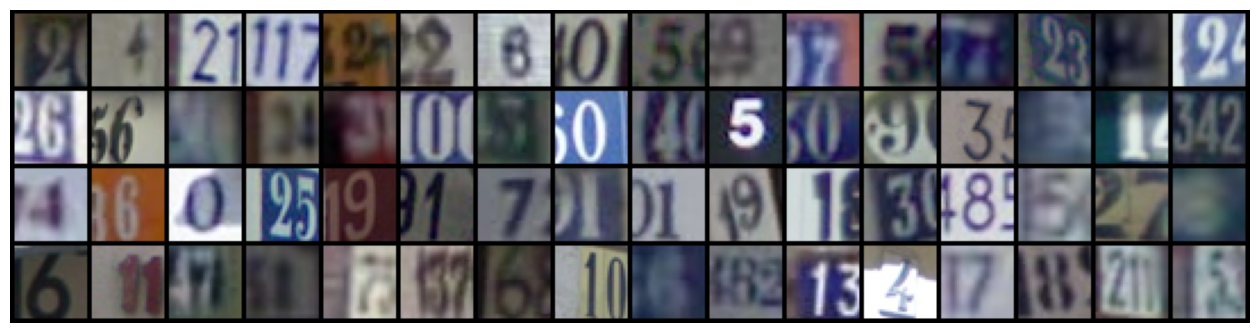

In [9]:
for images, labels in train_loader:
    print('labels.shape:', labels.shape)
    print('images.shape:', images.shape)
    print(labels[0])
    plt.figure(figsize=(16,8))
    #plt.set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [10]:
class ConvBlock(nn.Module):
    """
    Simple convolutional block: Conv + Norm + Act + Dropout
    """
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, add_norm=True, activation="ReLU", dropout=None):
        """ Module Initializer """
        super().__init__()
        assert activation in ["ReLU", "LeakyReLU", "Sigmoid", "Tanh", None]
        padding = kernel_size // 2
        
        block = []
        block.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride))
        if add_norm:
            block.append(nn.BatchNorm2d(out_channels))
        if activation is not None:
            nonlinearity = getattr(nn, activation, nn.ReLU)()
            if isinstance(nonlinearity, nn.LeakyReLU):
                nonlinearity.negative_slope = 0.2
            block.append(nonlinearity)
            
        if dropout is not None:
            block.append(nn.Dropout(dropout))
            
        self.block =  nn.Sequential(*block)

    def forward(self, x):
        """ Forward pass """
        y = self.block(x)
        return y


class ConvTransposeBlock(nn.Module):
    """
    Simple convolutional block: ConvTranspose + Norm + Act + Dropout
    """
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, add_norm=True, activation="ReLU", dropout=None):
        """ Module Initializer """
        super().__init__()
        assert activation in ["ReLU", "LeakyReLU", "Tanh", None]
        padding = kernel_size // 2
        
        block = []
        block.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, stride=stride))
        if add_norm:
            block.append(nn.BatchNorm2d(out_channels))
        if activation is not None:
            nonlinearity = getattr(nn, activation, nn.ReLU)()
            if isinstance(nonlinearity, nn.LeakyReLU):
                nonlinearity.negative_slope = 0.2
            block.append(nonlinearity)
        if dropout is not None:
            block.append(nn.Dropout(dropout))
            
        self.block =  nn.Sequential(*block)

    def forward(self, x):
        """ Forward pass """
        y = self.block(x)
        return y

In [11]:
class Reshape(nn.Module):
    """ Reshaping a vector in a given shape """
    
    def __init__(self, shape):
        """ """
        super().__init__()
        self.shape = shape
        
    def forward(self, x):
        """ """
        B, N = x.shape
        x = x.view(B, N, 1, 1)
        y = x.repeat(1, 1, *self.shape)
        return y

### Creating conditional GAN
The task was rather easy. We just needed to add label embedding and merge it with latent space. This was done both for generator and discriminator. Of course, certain dimensions needed to be changed accordingly

In [12]:
class Generator(nn.Module):
    """
    A fully convolutional generator using ReLU activations. 
    Takes as input a latent vector and outputs a fake sample.
       (B, latent_dim, 1, 1)  --> (B, num_channels, 32, 32)
    """
    def __init__(self, latent_dim=128, num_channels=3, base_channels=32, num_classes=10, label_embed_size=5):
        """ Model initializer """
        super().__init__()
        self.num_classes = num_classes
        self.label_embedding = nn.Embedding(num_classes, label_embed_size)
        layers = []
        for i in range(4):
            layers.append(
                ConvTransposeBlock(
                        in_channels=latent_dim+label_embed_size if i == 0 else base_channels * 2 ** (3-i+1),
                        out_channels=base_channels * 2 ** (3-i),
                        kernel_size=4,
                        stride=1 if i == 0 else 2,
                        add_norm=True,
                        activation="ReLU"
                    )
                )
        layers.append(
            ConvTransposeBlock(
                    in_channels=base_channels,
                    out_channels=num_channels,
                    kernel_size=4,
                    stride=2,
                    add_norm=False,
                    activation="Tanh"
                )
            )
        
        self.model = nn.Sequential(*layers)
        return
    
    def forward(self, z, labels):
        # pdb.set_trace()
        label_embed = self.label_embedding(labels)
        label_embed = label_embed.reshape([label_embed.shape[0], -1, 1, 1])
        z = torch.cat([z, label_embed], dim=1)  #merging label embedding and latent space
        """ Forward pass through generator """
        y = self.model(z)
        return y

In [13]:
class Discriminator(nn.Module):
    """ A fully convolutional discriminator using LeakyReLU activations. 
    Takes as input either a real or fake sample and predicts its autenticity.
       (B, num_channels, 32, 32)  -->  (B, 1, 1, 1)
    """
    def __init__(self, in_channels=1, out_dim=1, base_channels=32, dropout=0.3, num_classes=10):
        """ Module initializer """
        super().__init__()  
        self.num_classes = num_classes
        self.image_size = base_channels
        self.label_embedding = nn.Embedding(num_classes, self.image_size*self.image_size)
        layers = []
        for i in range(4):
            layers.append(
                ConvBlock(
                        in_channels=in_channels+1 if i == 0 else base_channels * 2 ** i, 
                        out_channels=base_channels * 2 ** (i + 1),
                        kernel_size=4,
                        add_norm=True,
                        activation="LeakyReLU",
                        dropout=dropout,
                        stride=2
                    )
                )
        layers.append(
                ConvBlock(
                        in_channels=base_channels * 16,
                        out_channels=out_dim,
                        kernel_size=4,
                        stride=4,
                        add_norm=False,
                        activation="Sigmoid"
                    )
                )
        
        self.model = nn.Sequential(*layers)
        return
      
    def forward(self, x, labels):
        """ Forward pass """
        # pdb.set_trace()
        label_embed = self.label_embedding(labels)
        label_embed = label_embed.reshape([label_embed.shape[0], 1, self.image_size,  self.image_size])
        x = torch.cat([x, label_embed], dim=1) #merging label embedding and latent space
        y = self.model(x)
        return y

In [14]:
discriminator = Discriminator(in_channels=3, out_dim=1, base_channels=32)
generator = Generator(latent_dim=256, num_channels=3, base_channels=32)

In [15]:
latent = torch.randn(16, 256, 1, 1)
labels = torch.full((16,), 1)
fake_img = generator(latent,labels)
score = discriminator(fake_img, labels)
print(f"{fake_img.shape = }")
print(f"{score.shape = }")

fake_img.shape = torch.Size([16, 3, 32, 32])
score.shape = torch.Size([16, 1, 1, 1])


In [16]:
# utils
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

def visualize_progress(loss_iters, train_loss, val_loss):
    """ Visualizing loss and accuracy """
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)

    smooth_loss = smooth(loss_iters, 31)
    ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_yscale("log")
    ax[0].set_title("Training Progress")

    smooth_loss = smooth(loss_iters, 31)
    START = 500
    N_ITERS = len(loss_iters)
    ax[1].plot(np.arange(START, N_ITERS), loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_yscale("log")
    ax[1].set_title(f"Training Progress from Iter {START}")

    epochs = np.arange(len(train_loss)) + 1
    ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
    ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("CE Loss")
    ax[2].set_title("Loss Curves")
    
def save_model(model, model_name, optimizer, epoch, exp_no = 69):
    """ Saving model checkpoint """
    
    if(not os.path.exists("experiments/experiment_"+model_name+"_"+str(exp_no)+"/models")):
        os.makedirs("experiments/experiment_"+model_name+"_"+str(exp_no)+"/models")
    savepath = "experiments/experiment_"+model_name+"_"+str(exp_no)+f"/models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, savepath)
    
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    
    return model, optimizer, epoch, stats

In [17]:
class Trainer:
    """
    Class for initializing GAN and training it
    """
    def __init__(self, generator, discriminator, latent_dim=128):
        """ Initialzer """
        self.latent_dim = latent_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.generator = generator.to(self.device)
        self.discriminator = discriminator.to(self.device)
        
        self.optim_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=3e-4, betas=(0.5, 0.9))
        self.optim_generator = torch.optim.Adam(self.generator.parameters(), lr=3e-4, betas=(0.5, 0.9))
        
        # REAL LABEL = 1
        # FAKE LABEL = 0
        # eps = 1e-10
        # self.criterion_d_real = lambda pred: torch.clip(-torch.log(1 - pred + eps), min=-10).mean()
        # self.criterion_d_fake = lambda pred: torch.clip(-torch.log(pred + eps), min=-10).mean()
        # self.criterion_g = lambda pred: torch.clip(-torch.log(1 - pred + eps), min=-10).mean()
        
        self.criterion_d_real = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
        self.criterion_d_fake = lambda pred: F.binary_cross_entropy(pred, torch.zeros(pred.shape[0], device=pred.device))
        self.criterion_g = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
        
        self.hist = {
            "d_real": [],
            "d_fake": [],
            "g": []
        }
        return
        
    def train_one_step(self, imgs, labels):
        """ 
        raining both models for one optimization step
        """
        self.generator.train()
        self.discriminator.train()
        
        # Sample from the latent distribution
        B = imgs.shape[0]
        latent = torch.randn(B, self.latent_dim, 1, 1).to(self.device)
        
        real_labels = torch.ones(batch_size, 1, device=self.device)
        fake_labels = torch.zeros(batch_size, 1, device=self.device)
        # ==== Training Discriminator ====
        self.optim_discriminator.zero_grad()
        # Get discriminator outputs for the real samples
        prediction_real = self.discriminator(imgs, labels)
        # Compute the loss function
        d_loss_real = self.criterion_d_real(prediction_real.view(B))

        # Generating fake samples with the generator
        fake_samples = self.generator(latent, labels)
        # Get discriminator outputs for the fake samples
        prediction_fake_d = self.discriminator(fake_samples.detach(), labels)  # why detach?
        # Compute the loss function
        d_loss_fake = self.criterion_d_fake(prediction_fake_d.view(B))
        (d_loss_real + d_loss_fake).backward()
        assert fake_samples.shape == imgs.shape
        
        # optimization step
        torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 3.0)
        self.optim_discriminator.step()
        
        # === Train the generator ===
        self.optim_generator.zero_grad()
        # Get discriminator outputs for the fake samples
        prediction_fake_g = self.discriminator(fake_samples, labels)
        # Compute the loss function
        g_loss = self.criterion_g(prediction_fake_g.view(B))
        g_loss.backward()
        # optimization step
        self.optim_generator.step()
        
        return d_loss_real, d_loss_fake, g_loss
    
    @torch.no_grad()
    def generate(self, number, N=64, device = None):
        """ Generating a bunch of images representing a given number using current state of generator.
        10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.
        """
        if device is None:
            device = self.device
        self.generator.eval()
        labels = torch.full((N,), number).to(device)
        latent = torch.randn(N, self.latent_dim, 1, 1).to(device)
        imgs = self.generator(latent, labels)
        imgs = imgs * 0.5 + 0.5
        return imgs
    
    def load_models(self, path_generator, path_discriminator):
        generator_checkpoint = torch.load(path_generator)
        discriminator_checkpoint = torch.load(path_discriminator)
        self.generator.load_state_dict(generator_checkpoint['model_state_dict'])
        self.optim_generator.load_state_dict(generator_checkpoint['optimizer_state_dict'])
        self.discriminator.load_state_dict(discriminator_checkpoint['model_state_dict'])
        self.optim_discriminator.load_state_dict(discriminator_checkpoint['optimizer_state_dict'])

        
    def train(self, data_loader, N_iters=10000, init_step=0):
        """ Training the models for several iterations """
        
        progress_bar = tqdm(range(init_step, N_iters))
        running_d_loss = 0
        running_g_loss = 0
        
        iter_ = 0
        for i in progress_bar:
            for real_batch, labels in data_loader:
                # pdb.set_trace()
                real_batch = real_batch.to(self.device)
                labels = labels.to(self.device)
                d_loss_real, d_loss_fake, g_loss = self.train_one_step(imgs=real_batch, labels=labels)
                d_loss = d_loss_real + d_loss_fake
                
            
                # updating progress bar
                progress_bar.set_description(f"Ep {i+1} Iter {iter_}: D_Loss={round(d_loss.item(),5)}, G_Loss={round(g_loss.item(),5)})")
                
                # adding stuff to tensorboard
                # Log metrics to wandb
                wandb.log({"Loss/Generator Loss": g_loss.item(), "global_step": iter_, "epoch": i+1})
                wandb.log({"Loss/Discriminator Loss": d_loss.item(), "global_step": iter_, "epoch": i+1})
                wandb.log({"Loss/Discriminator Losses/Real Images Loss": d_loss_real.item(), "global_step": iter_, "epoch": i+1})
                wandb.log({"Loss/Discriminator Losses/Fake Images Loss": d_loss_fake.item(), "global_step": iter_, "epoch": i+1})
                wandb.log({"Comb_Loss/Losses/Discriminator": d_loss.item(), "global_step": iter_, "epoch": i+1})
                wandb.log({"Comb_Loss/Losses/Generator": g_loss.item(), "global_step": iter_, "epoch": i+1})
                
                if(iter_ % 200 == 0):
                    imgs = self.generate(1) #Generate ones
                    grid = torchvision.utils.make_grid(imgs, nrow=8)
                    images = wandb.Image(grid, caption="Top: Output, Bottom: Input")
                    wandb.log({"generated_images": images})
                    torchvision.utils.save_image(grid, os.path.join(os.getcwd(), "imgs", "training", f"imgs_{iter_}.png"))
                if (i % 10 == 0):
                    save_model(self.generator, "generator", self.optim_generator, i, exp_no = 1)
                    save_model(self.discriminator, "discriminator", self.optim_discriminator, i, exp_no = 1)
                iter_ = iter_ + 1 
                
        return

In [18]:
# shutil.rmtree(GAN_LOGS)
# writer = SummaryWriter(GAN_LOGS)

In [19]:
generator = Generator(latent_dim=256, num_channels=3, base_channels=32)
discriminator = Discriminator(in_channels=3, out_dim=1, base_channels=32)

trainer = Trainer(generator=generator, discriminator=discriminator, latent_dim=256)

In [20]:
generator_path = '/home/user/rogf1/CudaVisionWS23/Assignment6/experiments/experiment_generator_1/models/checkpoint_epoch_90.pth'
discriminator_path = '/home/user/rogf1/CudaVisionWS23/Assignment6/experiments/experiment_discriminator_1/models/checkpoint_epoch_90.pth'

In [21]:
trainer.load_models(generator_path, discriminator_path)

In [ ]:
with wandb.init(project="DCGAN6a"):
    trainer.train(train_loader, N_iters = 100)
wandb.finish()

Below image depicts loss plots for generator and discriminator throughout training

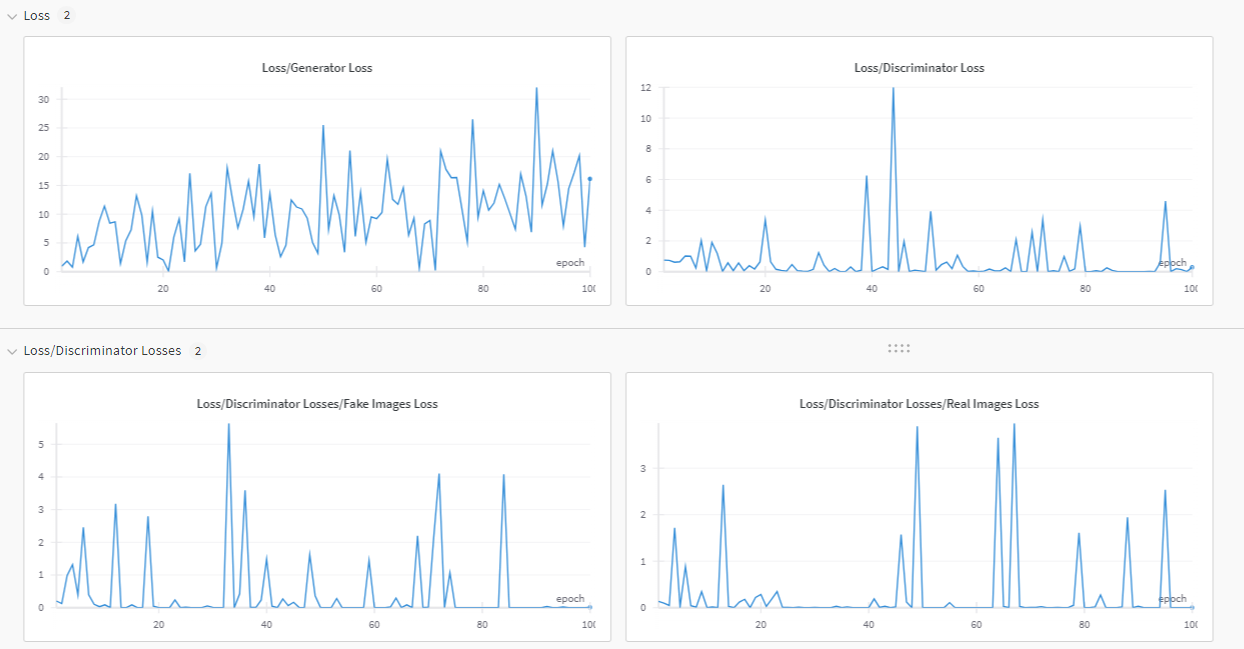

In [17]:
from IPython.display import display, Image
display(Image(filename='losses_cGAN.png'))

### Training discussion
While loss plots may seem a little bit unstable (which they are), results are satisfactory so we didn't worry that much about it. to improve stability we could apply f.e. Wasserstein GAN or DRAGAN architectures.

In [ ]:
import imageio

images = []
img_path = os.path.join(os.getcwd(), "imgs", "training")

# making list with images and orting by iteration
img_list = [img for img in os.listdir(img_path) if "imgs_" in img]
sorted_imgs = sorted(img_list, key=lambda x: int(x.split("_")[1].split(".")[0]))
for img in sorted_imgs:
    images.append(imageio.imread(os.path.join(img_path, img)))
imageio.mimsave(os.path.join(img_path, "progress.gif"), images)

### Generating images
Images are generated using ```trainer.generate(number)``` method, where an argument ```number``` represents a digit we want to display.

In [23]:
def display_images(imgs, rows, cols):
    fig = plt.figure(figsize=(10, 10))
    for i in range(rows * cols):
        img = imgs[i].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))  # Change (C, H, W) to (H, W, C) for plotting
        ax = fig.add_subplot(rows, cols, i+1)
        ax.axis('off')
        ax.imshow(img)
    plt.show()

In [24]:
imgs = trainer.generate(number = 4) # passing 4 because we want to generate 4
grid = torchvision.utils.make_grid(imgs, nrow=9)

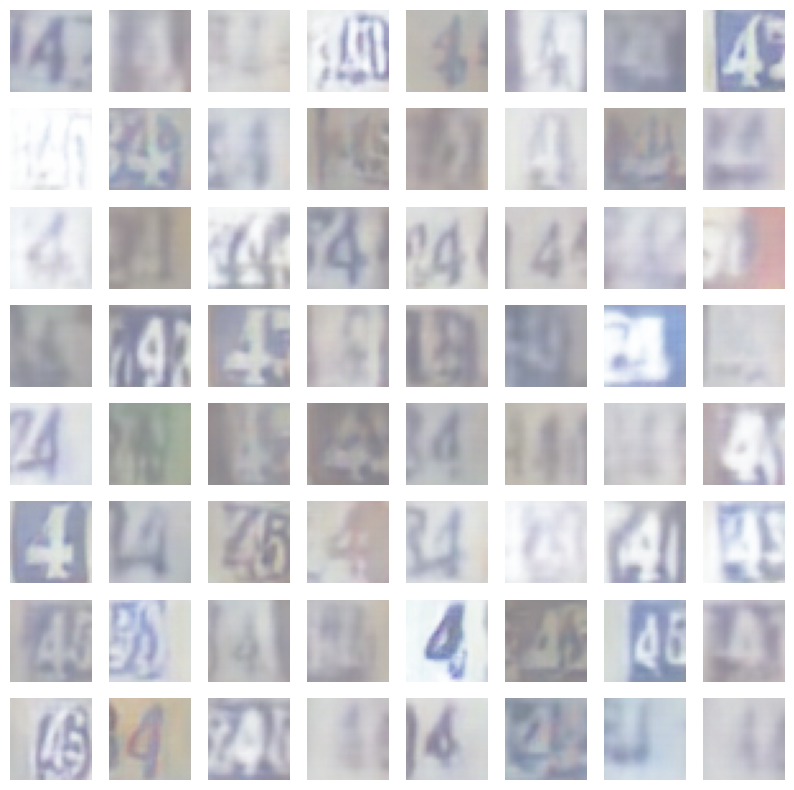

In [25]:
display_images(imgs, rows=8, cols=8)  # Adjust rows and cols as needed

In [26]:
imgs = trainer.generate(number = 7) # same thing but with 7
grid = torchvision.utils.make_grid(imgs, nrow=9)

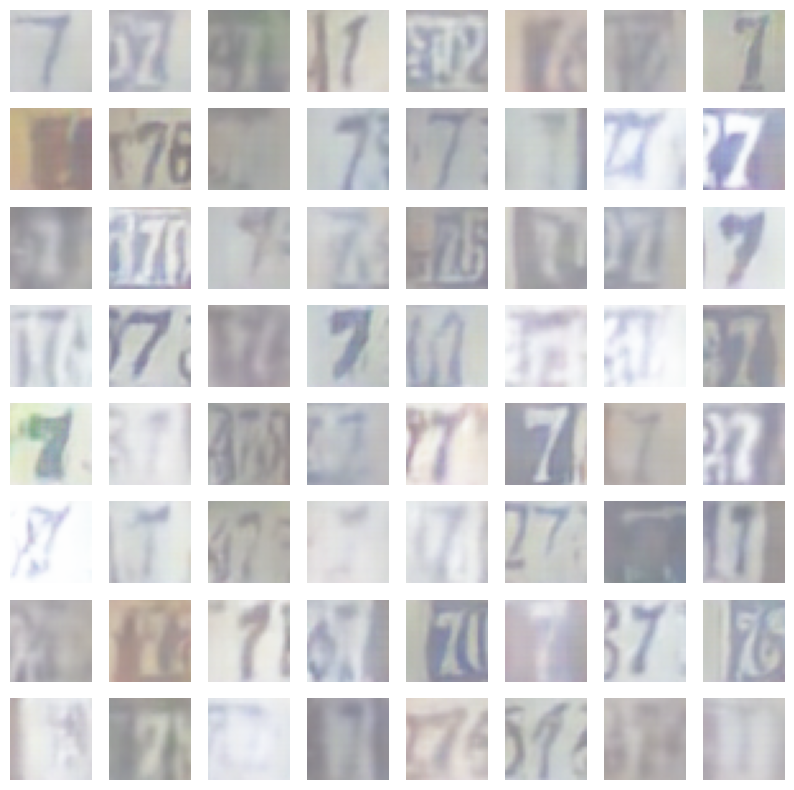

In [27]:
display_images(imgs, rows=8, cols=8)  # Adjust rows and cols as needed

### Comments
This task didn't introduce much changes with respect to the tutorial, but we needed to intoduce label embedding for conditional GAN to be successful. Generated images could of course, be a little bit better, but nevertheless, the digits are recognizable and differ from each other.

# Task 2

In [1]:
import torch
import os
import torchvision
from torchvision.transforms import v2
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
from PIL import Image, ImageOps
import torch
import pdb
import numpy as np
import yaml
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
from template import utils
from torchvision.utils import save_image
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch.nn.functional as F
import wandb

wandb.login()

import warnings
warnings.filterwarnings("ignore")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: skywalkerlke (luke_team). Use `wandb login --relogin` to force relogin


In [4]:
# setting config
config = yaml.safe_load(open("config.yaml"))
batch_size = int(config["BATCH_SIZE"])

print(f"Our config: {config}")

Our config: {'BATCH_SIZE': 128, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [21]:
transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(3)], [0.5 for _ in range(3)])
        ])

In [22]:
train_dataset = torchvision.datasets.CelebA(root='./data', split='train',
                                        download=True, transform=transform)
valid_dataset = torchvision.datasets.CelebA(root='./data', split='valid',
                                       download=True, transform=transform)
test_dataset = torchvision.datasets.CelebA(root='./data', split='test',
                                       download=True, transform=transform)

#create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


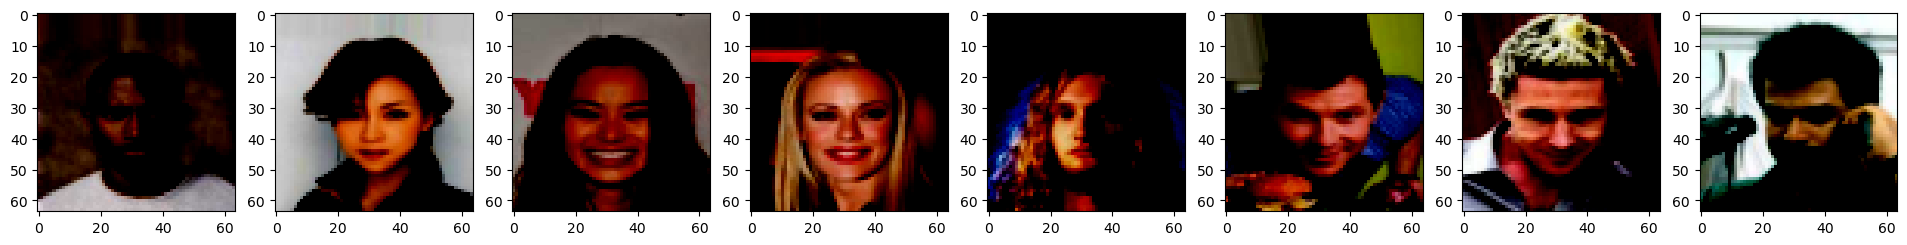

In [23]:
N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().reshape(3,64,64).transpose(1, 2, 0)
    ax[i].imshow(img)
    #ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    #ax[i].axis("off")
plt.show()

In [8]:
# Code was heavily inspired from the following Aladdin Persson youtube tutorial: https://www.youtube.com/watch?v=IZtv9s_Wx9I
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size = 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1),
            self._block(features_d*2, features_d*4, 4, 2, 1),
            self._block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding,
                      bias = False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            )
    def forward(self, x):
        return self.disc(x)
    
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: batch, z_dim, 1, 1
            self._block(z_dim, features_g*16, 4, 1, 0),
            self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g *4, 4, 2, 1),
            self._block(features_g*4, features_g *2, 4, 2, 1),
            nn.ConvTranspose2d( features_g*2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(), # just copying the DCGAN paper

        )
    def forward(self, x):
        return self.gen(x)

        
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1)
    gen = Generator(z_dim, in_channels, 8)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W)

test()


In [9]:
import torchmetrics
from torchmetrics.image.fid import FrechetInceptionDistance


def calculate_fid(gen, max_steps = 100):
    with torch.no_grad():
        fid = FrechetInceptionDistance(feature=64, normalize = True)
        # Torchmetrics implementation does not use cuda for some reason
        gen = gen.eval()
        gen = gen.to('cpu')
        max_steps = 100
        steps = 0
        for i, (test_data, _) in enumerate(testloader):
            if steps >= max_steps:
                break
            test_data = test_data.to('cpu')
            noise_fid = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to('cpu')
            sample = gen(noise_fid)
            fid.update(sample, real=False)
            fid.update(test_data, real=True)
            steps += 1
        distance = fid.compute()
        gen = gen.to(device)
        gen = gen.train()

    return distance

## Training Setup

In [10]:
config = {
    'LEARNING_RATE': 2e-4,
    'BATCH_SIZE': 64,
    'CHANNELS_IMG': 3,
    'NOISE_DIM': 100,
    'NUM_EPOCHS': 20,
    'FEATURES_DISC': 64,
    'FEATURES_GEN': 64
}

LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 20
FEATURES_DISC = 64
FEATURES_GEN = 64

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

# Setup taken from the paper, in order to ensure learning
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [12]:
generator_loss_epoch = []
discriminator_loss_epoch = []
fi_distance = []

# Hyperparameters etc.
with wandb.init(project='DCGAN', config = config):
    # use this later for plotting
    fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
    step = 0

    gen.train()
    disc.train()

    for epoch in range(NUM_EPOCHS):
        discriminator_loss = []
        generator_loss = []

        progress_bar = tqdm(enumerate(dataloader), total = len(dataloader))
        for batch_idx, (real, _) in progress_bar:
            real = real.to(device)
            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
            fake = gen(noise)

            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            disc_real = disc(real).reshape(-1)
            loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake.detach()).reshape(-1)
            loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2
            discriminator_loss.append(loss_disc.item())
            disc.zero_grad()
            loss_disc.backward()
            opt_disc.step()

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            output = disc(fake).reshape(-1)
            loss_gen = criterion(output, torch.ones_like(output))
            generator_loss.append(loss_gen.item())
            gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()

            # Print to Wandb and to console
            if batch_idx % 100 == 0:
                progress_bar.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}")
                
                with torch.no_grad():
                    fake = gen(fixed_noise)
                    # take out (up to) 32 examples
                    img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                    img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                    images = wandb.Image(img_grid_fake, caption="Generated Images")
                    wandb.log({"images_fake": images})
                    images = wandb.Image(img_grid_real, caption="Real images")
                    wandb.log({"images_real": images})

                    step += 1
                    wandb.log({'epoch': epoch, 'Generator Loss':loss_gen, 'Discriminator Loss': loss_disc})

            generator_loss_epoch.append(np.mean(generator_loss))
            discriminator_loss_epoch.append(np.mean(discriminator_loss))

        fid = FrechetInceptionDistance(feature=64, normalize = True)
        # Torchmetrics implementation does not use cuda for some reason
        fi_distance.append(calculate_fid(gen, max_steps = 50))
        
        wandb.log({'fid_per_epoch': fi_distance[-1]})

'generator_loss_epoch = []\ndiscriminator_loss_epoch = []\nfi_distance = []\n\n# Hyperparameters etc.\nwith wandb.init(project=\'DCGAN\', config = config):\n    # use this later for plotting\n    fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)\n    step = 0\n\n    gen.train()\n    disc.train()\n\n    for epoch in range(NUM_EPOCHS):\n        discriminator_loss = []\n        generator_loss = []\n\n        progress_bar = tqdm(enumerate(dataloader), total = len(dataloader))\n        for batch_idx, (real, _) in progress_bar:\n            real = real.to(device)\n            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)\n            fake = gen(noise)\n\n            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))\n            disc_real = disc(real).reshape(-1)\n            loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))\n            disc_fake = disc(fake.detach()).reshape(-1)\n            loss_disc_fake = criterion(disc_fake, torch.zeros_like

In [13]:
def save_model_gen(model, optimizer, epoch, stats, exp_no = 9):
    """ Saving model checkpoint """
    
    if(not os.path.exists("experiments/experiment_"+str(exp_no)+"/models")):
        os.makedirs("experiments/experiment_"+str(exp_no)+"/models")
    savepath = "experiments/experiment_"+str(exp_no)+f"/models/checkpoint_gen_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    
    return

def save_model_disc(model, optimizer, epoch, stats, exp_no = 9):
    """ Saving model checkpoint """

    if(not os.path.exists("experiments/experiment_"+str(exp_no)+"/models")):
        os.makedirs("experiments/experiment_"+str(exp_no)+"/models")
    savepath = "experiments/experiment_"+str(exp_no)+f"/models/checkpoint_disc_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)

    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats

In [14]:
gen, opt_gen, epoch, stats = load_model(gen, opt_gen, savepath='/home/user/lschulze/projects/CudaVisionWS23/Assignment5/experiments/experiment_9/models/checkpoint_gen_epoch_20.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


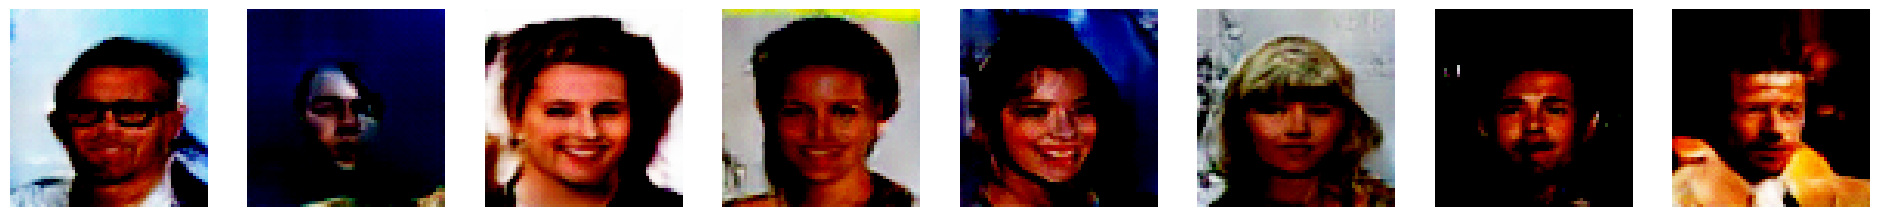

In [65]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

gen = gen.to(device)
gen = gen.eval()
noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
fake = gen(noise)

for i in range(N_IMGS):
    img = fake[i].cpu().detach().numpy().reshape(3,64,64).transpose(1, 2, 0)
    ax[i].imshow(img)
    #ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    ax[i].axis("off")
plt.show()

We observe that our generations look very nice. From far away one might not even detect that the images are artificially generated. We also observe, that the images are quite diverse. We note, that the images have a slight red tone however. This is probably due to our initial choice of input normalization. Due to time constraints we were not able to optimize this further, but strongly believe that further improvement is possible in this regard.

## Plots

In [26]:
from template import utils

In [32]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

In [35]:
def plot_loss(train_loss_list = [], val_loss_list = []):
    """Plots train and validation loss.

    Args:
        train_loss_list (list, optional): Training loss. Defaults to [].
        val_loss_list (list, optional): Validation loss. Defaults to [].
    """
    plt.style.use('seaborn')
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(18,5)

    smooth_train_loss = smooth(train_loss_list, 31)
    smooth_val_loss = smooth(val_loss_list, 31)

    ax[0].plot(train_loss_list, c="blue", label="Discriminator Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_train_loss, c="red", label="Smoothed Discriminator Loss", linewidth=3)
    ax[0].plot(val_loss_list, c="green", label="Generator Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_val_loss, c="yellow", label="Smoothed Generator Loss", linewidth=3)


    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_title("Training Progress (linearscale)")

    ax[1].plot(train_loss_list, c="blue", label="Discriminator Loss", linewidth=3, alpha=0.5)
    ax[1].plot(smooth_train_loss, c="red", label="Smoothed Discriminator Loss", linewidth=3)
    ax[1].plot(val_loss_list, c="green", label="Generator Loss", linewidth=3, alpha=0.5)
    ax[1].plot(smooth_val_loss, c="yellow", label="Smoothed Generator Loss", linewidth=3)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_yscale("log")
    ax[1].set_title("Training Progress (logscale)")
    plt.show()

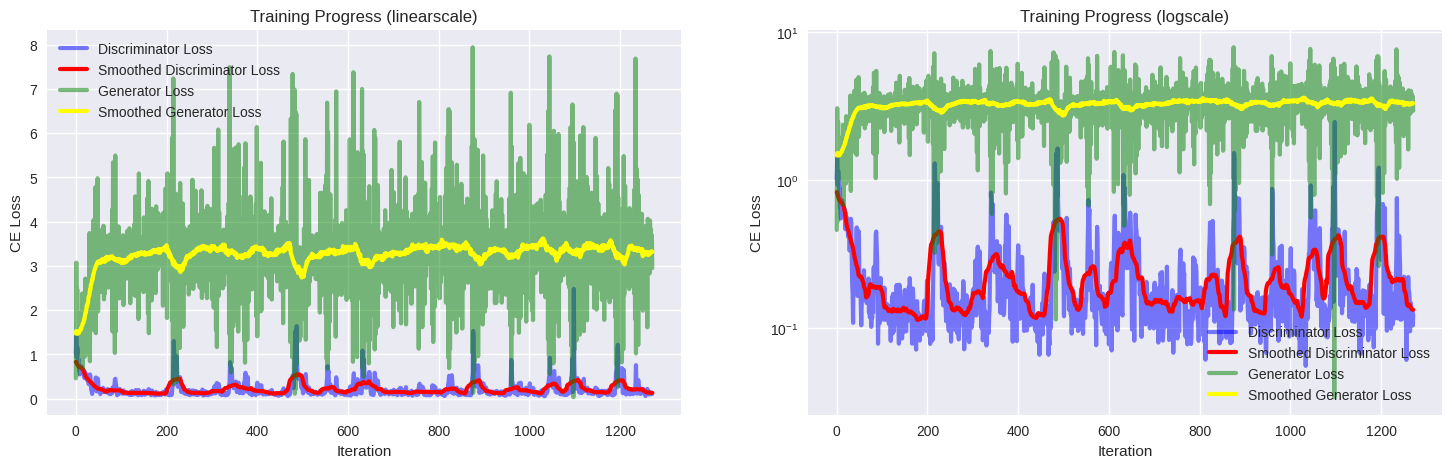

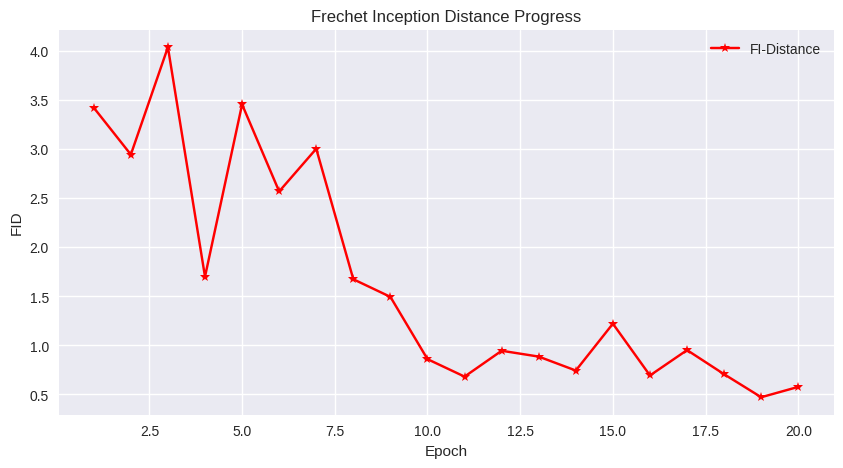

In [37]:
plot_loss(stats[0], stats[1])

epochs = range(1, len(stats[2]) + 1)

plt.figure(figsize=(10, 5))


plt.plot(epochs, stats[2], 'r*-', label='FI-Distance')
plt.title('Frechet Inception Distance Progress')
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.legend()
plt.grid(True)
plt.show()

The Generator and Discriminator Loss appear to be very spiky and unstable. This is expected and good however, since the Generator and Discriminator are continuously adapting to each other. The development of the FID also looks as expected. The longer we train our models. The better our generator becomes. At around epoch 13 our generation ability (according to the FI-distance) appears to converge.